# How to extract digitizer peaks with the SCS Toolbox

## Workflow during a beamtime

1. Record first data with signal on digitizer.
2. Find peak integration parameters using `check_peak_params()`.
3. Update the new parameters in DAMNIT, so that for each new run, automatic processing of each run is performed and saved in `usr/processed_runs` folder. As long as the right bunch pattern is selected for peak extraction, there is no need to care about the number of pulses / period, as they will be adjusted to match the bunch pattern of each run.
4. For analysis, load digitizer data using `load_processed_peaks()` or `load_all_processed_peaks()`. This is much faster than loading the raw traces and re-performing peak integration.
5. Checking the integration parameters used for the processed data can be done via `check_processed_peaks_params()`.

## Peak-integration parameters

In [1]:
import toolbox_scs as tb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.constrained_layout.use'] = True

Cupy is not installed in this environment, no access to the GPU


Extracting peaks from a raw trace is done using the `get_digitizer_peaks()` function of the SCS Toolbox, by integration over the area of the peak and subtraction of a baseline. For one peak, the parameters `pulseStart` and `pulseStop` (sample numbers in the raw trace) define the integration region  and `baseStart` and `baseStop` define the baseline region. In most cases, the pulse pattern is regular and there are `npulses` separated by a `period`. The peak extraction is repeated for each peak, with `pulseStart`, `pulseStop`, `baseStart` and `baseStop` shifted by the period.

An example of integration parameters:

In [2]:
params = {'pulseStart': 100,
          'pulseStop': 120,
          'baseStart': 80,
          'baseStop': 99,
          'period': 96,
          'npulses': 25}

If the pattern is not regular, a list of starting positions can be provided to `pulseStart`, while `pulseStop`, `baseStart`, `baseStop` remain integers and relate to the first peak only. In such case, `period` does not have a meaning and `npulses` is equal to `len(pulseStart)`:

In [3]:
params = {'pulseStart': [100, 200, 500, 600, 900, 1000, 2000, 10000, 15500],
          'period': 0,
          'pulseStop': 110,
          'baseStop': 99,
          'baseStart': 90,
          'npulses': 9}

Let's assume that we are interested in the APD signal on diode 8 looking at the FEL, which corresponds to Ch9 of Fast ADC 2 (mnemonic `FastADC2_9raw`). We can check how the peak-finding algorithm performs by using `tb.check_peak_parameters()` and inspecting the found regions of integration. This shows a plot with the first and last pulses identified by the peak-finding algorithm and displays the region of integration and the region for baseline subtraction. The function returns a dictionnary `good_params` that has all parameters necessary to perform the trapezoidal integration over the digitizer trace.


Bunch pattern sase3: 400 pulses, 96 samples between two pulses
Auto-find peak parameters:  400 pulses, 96 samples between two pulses


{'pulseStart': 6763,
 'period': 96,
 'pulseStop': 6770,
 'baseStop': 6762,
 'baseStart': 6757,
 'npulses': 400}

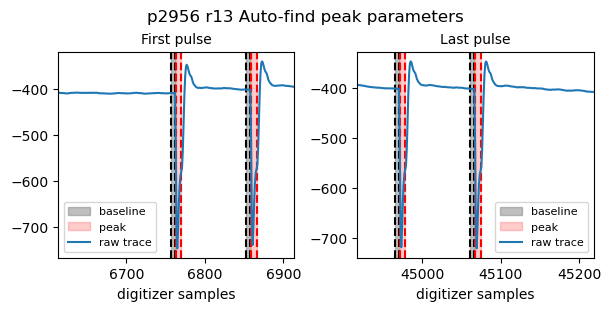

In [4]:
proposal, runNB = 2956, 13
good_params = tb.check_peak_params(proposal, runNB, 'FastADC2_9raw', bunchPattern='sase3')
good_params

## Extracting peaks

The integration parameters are either user-provided or automatically computed by a peak-finding algorithm in `get_digitizer_peaks()` and `check_peak_params()`. The bunch pattern, when provided, is used to determine the parameters or to check consistency with user-provided parameters, and to align the pulse ID. The minimum required inputs to extract peaks are:
* the `bunchPattern` source ('sase3' if the device is looking at the FEL or 'scs_ppl' if the device is looking at the PP laser), leaving `integParams=None` to let the peak-finding algorithm operate.
* or `integParams` dict including `pulseStart`, `pulseStop`, `baseStart`, `baseStop`, `period` and `npulses` keys.

In most cases, automatic peak finding provides good integration parameters. If it fails, or if we want to define fixed parameters to consistently analyze a series of runs, it is necessary to provide the parameters via `integParams`.

If both the bunch pattern and the integration parameters are provided, the `period` and `npulses` of the user-provided parameters (`integParams`) will be overriden (with a warning in case of mismatch), except if `pulseStart` is a list (e.g. case of irregular patterns).


Once the parameters are found, we can extract the peaks using `get_digitizer_peaks()`, with `bunchPattern='sase3'`.

In [5]:
peaks = tb.get_digitizer_peaks(proposal, runNB, 'FastADC2_9raw', integParams=good_params, bunchPattern='sase3')
peaks

<xarray.Dataset> Size: 25MB
Dimensions:          (trainId: 7898, sa3_pId: 400)
Coordinates:
  * trainId          (trainId) uint64 63kB 1501374970 1501374971 ... 1501382869
  * sa3_pId          (sa3_pId) int32 2kB 772 776 780 784 ... 2356 2360 2364 2368
Data variables:
    FastADC2_9peaks  (trainId, sa3_pId) float64 25MB -1.04e+04 ... -1.866e+03

We see here that `peaks` has a variable `FastADC2_9peaks` which has dimensions `['trainId', 'sa3_pId']`, which is exactly what we wanted: the raw traces were automatically transformed into vectors of length `sa3_pId`.



Note that we could also have ommitted the parameter `integParams` in `get_digitizer_peaks()` to force the automatic peak finding algorithm:

In [6]:
peaks = tb.get_digitizer_peaks(proposal, runNB, 'FastADC2_9raw', bunchPattern='sase3')

## If the peak-finding algorithm fails


The best strategy is to inspect the raw trace with `get_dig_avg_trace()` or use `check_peak_params()` with `show_all=True` and determine the regions of integration manually. Once the integration parameter dictionnary is created, one can feed it to the `integParams` argument in `get_digitizer_peaks()`.

## Save / load processed peaks

If we have found good integration parameters, it is worth saving the integrated peaks as processed data. This can be done by selecting `save=True` in `get_digitizer_peaks()`. The location can be chosen by `subdir`, by default it goes to the `usr/processed_runs` folder of the proposal.

In [7]:
peaks = tb.get_digitizer_peaks(proposal, runNB, 'FastADC2_9raw', integParams=good_params, bunchPattern='sase3',
                               save=True)

saved data into /gpfs/exfel/exp/SCS/202202/p002956/usr/processed_runs/r0013/r0013-digitizers-data.h5.


To load the processed data:

In [8]:
tb.load_processed_peaks(proposal, runNB, 'FastADC2_9peaks')

<xarray.DataArray 'FastADC2_9peaks' (trainId: 7898, sa3_pId: 400)> Size: 25MB
array([[-10396.5, -21040.5, -11618. , ...,  -2953. , -14307.5,  -9120. ],
       [-14979.5,  -3093.5,  -8993. , ...,  -5679.5,  -4255. , -25531. ],
       [-22282. ,  -2814. , -21852.5, ..., -14205.5,  -8499.5, -13072. ],
       ...,
       [  -607.5,     99. ,   -660. , ...,  -1162.5,  -1217. ,   -808. ],
       [  -999.5,   -681. ,   -327. , ...,  -1800. ,   -935. ,   -660. ],
       [ -1075. ,  -1200. ,   -358. , ...,   -753. ,   -864. ,  -1866.5]])
Coordinates:
  * trainId  (trainId) uint64 63kB 1501374970 1501374971 ... 1501382869
  * sa3_pId  (sa3_pId) int32 2kB 772 776 780 784 788 ... 2356 2360 2364 2368
Attributes:
    FastADC2_9peaks_pulseStart:  6763
    FastADC2_9peaks_period:      96
    FastADC2_9peaks_pulseStop:   6770
    FastADC2_9peaks_baseStop:    6762
    FastADC2_9peaks_baseStart:   6757
    FastADC2_9peaks_npulses:     400

Note that the attributes are the peak integration parameters used for peak extraction.

It is also possible to load the entire dataset containing the peaks and average traces of all the processed sources by ommitting the `mnemonic` argument:

In [9]:
tb.load_processed_peaks(proposal, runNB)

<xarray.Dataset> Size: 26MB
Dimensions:          (trainId: 7898, sa3_pId: 400, sampleId: 100000)
Coordinates:
  * trainId          (trainId) uint64 63kB 1501374970 1501374971 ... 1501382869
  * sa3_pId          (sa3_pId) int32 2kB 772 776 780 784 ... 2356 2360 2364 2368
Dimensions without coordinates: sampleId
Data variables:
    FastADC2_9peaks  (trainId, sa3_pId) float64 25MB -1.04e+04 ... -1.866e+03
    FastADC2_9avg    (sampleId) float64 800kB -411.8 -412.0 ... -411.3 -411.2
Attributes:
    FastADC2_9peaks_pulseStart:  6763
    FastADC2_9peaks_period:      96
    FastADC2_9peaks_pulseStop:   6770
    FastADC2_9peaks_baseStop:    6762
    FastADC2_9peaks_baseStart:   6757
    FastADC2_9peaks_npulses:     400

It is also possible to check the integration parameters that were used for peak extraction:

{'pulseStart': 6763,
 'period': 96,
 'pulseStop': 6770,
 'baseStop': 6762,
 'baseStart': 6757,
 'npulses': 400}

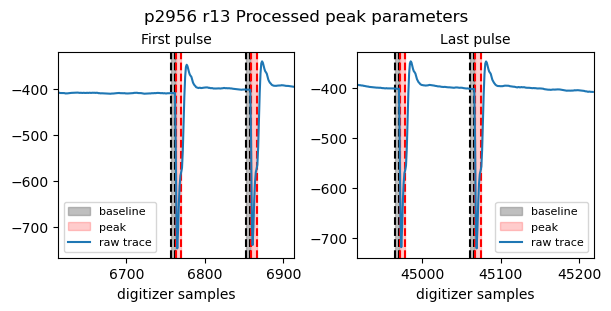

In [10]:
tb.check_processed_peak_params(proposal, runNB, 'FastADC2_9peaks')

## Example of irregular PPL pattern

Bunch pattern scs_ppl: Not a regular pattern. 192 pulses, pulse_ids=[   0    4    8   12   16   20   24   28   32   36   40   44   48   52
   56   60   64   68   72   76   80   84   88   92  192  196  200  204
  208  212  216  220  224  228  232  236  240  244  248  252  256  260
  264  268  272  276  280  284  384  388  392  396  400  404  408  412
  416  420  424  428  432  436  440  444  448  452  456  460  464  468
  472  476  576  580  584  588  592  596  600  604  608  612  616  620
  624  628  632  636  640  644  648  652  656  660  664  668  768  772
  776  780  784  788  792  796  800  804  808  812  816  820  824  828
  832  836  840  844  848  852  856  860  960  964  968  972  976  980
  984  988  992  996 1000 1004 1008 1012 1016 1020 1024 1028 1032 1036
 1040 1044 1048 1052 1152 1156 1160 1164 1168 1172 1176 1180 1184 1188
 1192 1196 1200 1204 1208 1212 1216 1220 1224 1228 1232 1236 1240 1244
 1344 1348 1352 1356 1360 1364 1368 1372 1376 1380 1384 1388 1392 1396
 1400 140

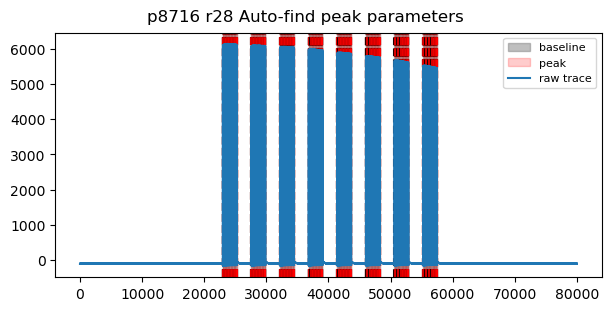

In [11]:
# irregular pattern
proposal, runNB, field = 8716, 28, 'I0_ILHraw'
params = tb.check_peak_params(proposal, runNB, field,
                              bunchPattern='scs_ppl', show_all=True)